In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')
from matplotlib_scalebar.scalebar import ScaleBar

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import zarr
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import cm

from skimage.measure import regionprops_table, label
import matplotlib

plt.style.use(["science", 'nature'])

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6



In [2]:
human_regionprops_dirs = glob("../../human_annotation_quality/*/masks/masks.zarr")
gt_dirs = sorted(glob("../../human_annotation_quality/projection_analysis_cw//training_data/*_masks*"))


In [3]:
human_regionprops = []
for human_regionprops_dir in human_regionprops_dirs:
    imgs = zarr.open(human_regionprops_dir)
    for i, gt_dir in enumerate(gt_dirs):
        projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
        wavelength = float(wavelength)
        properties = pd.DataFrame(regionprops_table(label(imgs[i]) , properties = ["area", "minor_axis_length"])) * 0.065
        properties["Projection"] = projection
        properties["Wavelength"] = wavelength
        human_regionprops.append(properties)
human_regionprops = pd.concat(human_regionprops)
human_regionprops["Mask"] = "Human"

gt_regionprops = []
for gt_dir in gt_dirs:
    projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
    wavelength = float(wavelength)
    properties = pd.DataFrame(regionprops_table(label(np.array(Image.open(gt_dir))), properties = ["area", "minor_axis_length"]))/3 * 0.065
    properties["Projection"] = projection
    properties["Wavelength"] = wavelength
    gt_regionprops.append(properties)
gt_regionprops = pd.concat(gt_regionprops)
gt_regionprops["Mask"] = "Ground truth"

In [4]:
all_regionprops = pd.concat([gt_regionprops, human_regionprops])

In [5]:
all_regionprops["Projection/Wavelength"] = "Proj " +all_regionprops["Projection"] + "\n" + all_regionprops["Wavelength"].astype(str)+ "um"

Text(0, 0.5, 'Width ($\\mu$m)')

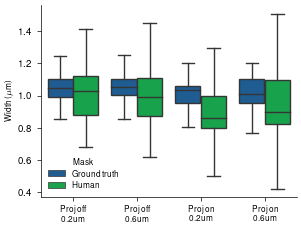

In [11]:
#annotation_ax_1 = plt.subplot2grid((18*2, 16), (13*2-1, 10), colspan=8, rowspan=4*2+1)
sns.boxplot(data = all_regionprops, y = "minor_axis_length", x = "Projection/Wavelength", hue = "Mask", showfliers = False)
plt.xlabel("")
plt.ylabel("Width ($\mu$m)")
#plt.ylim(0, 2)
#move_legend(annotation_ax_1, (-.15,1.02), ncol=3, title="")
#plt.text(-.03, 1.195, 'i)', ha='left', va='top', transform=annotation_ax_1.transAxes)


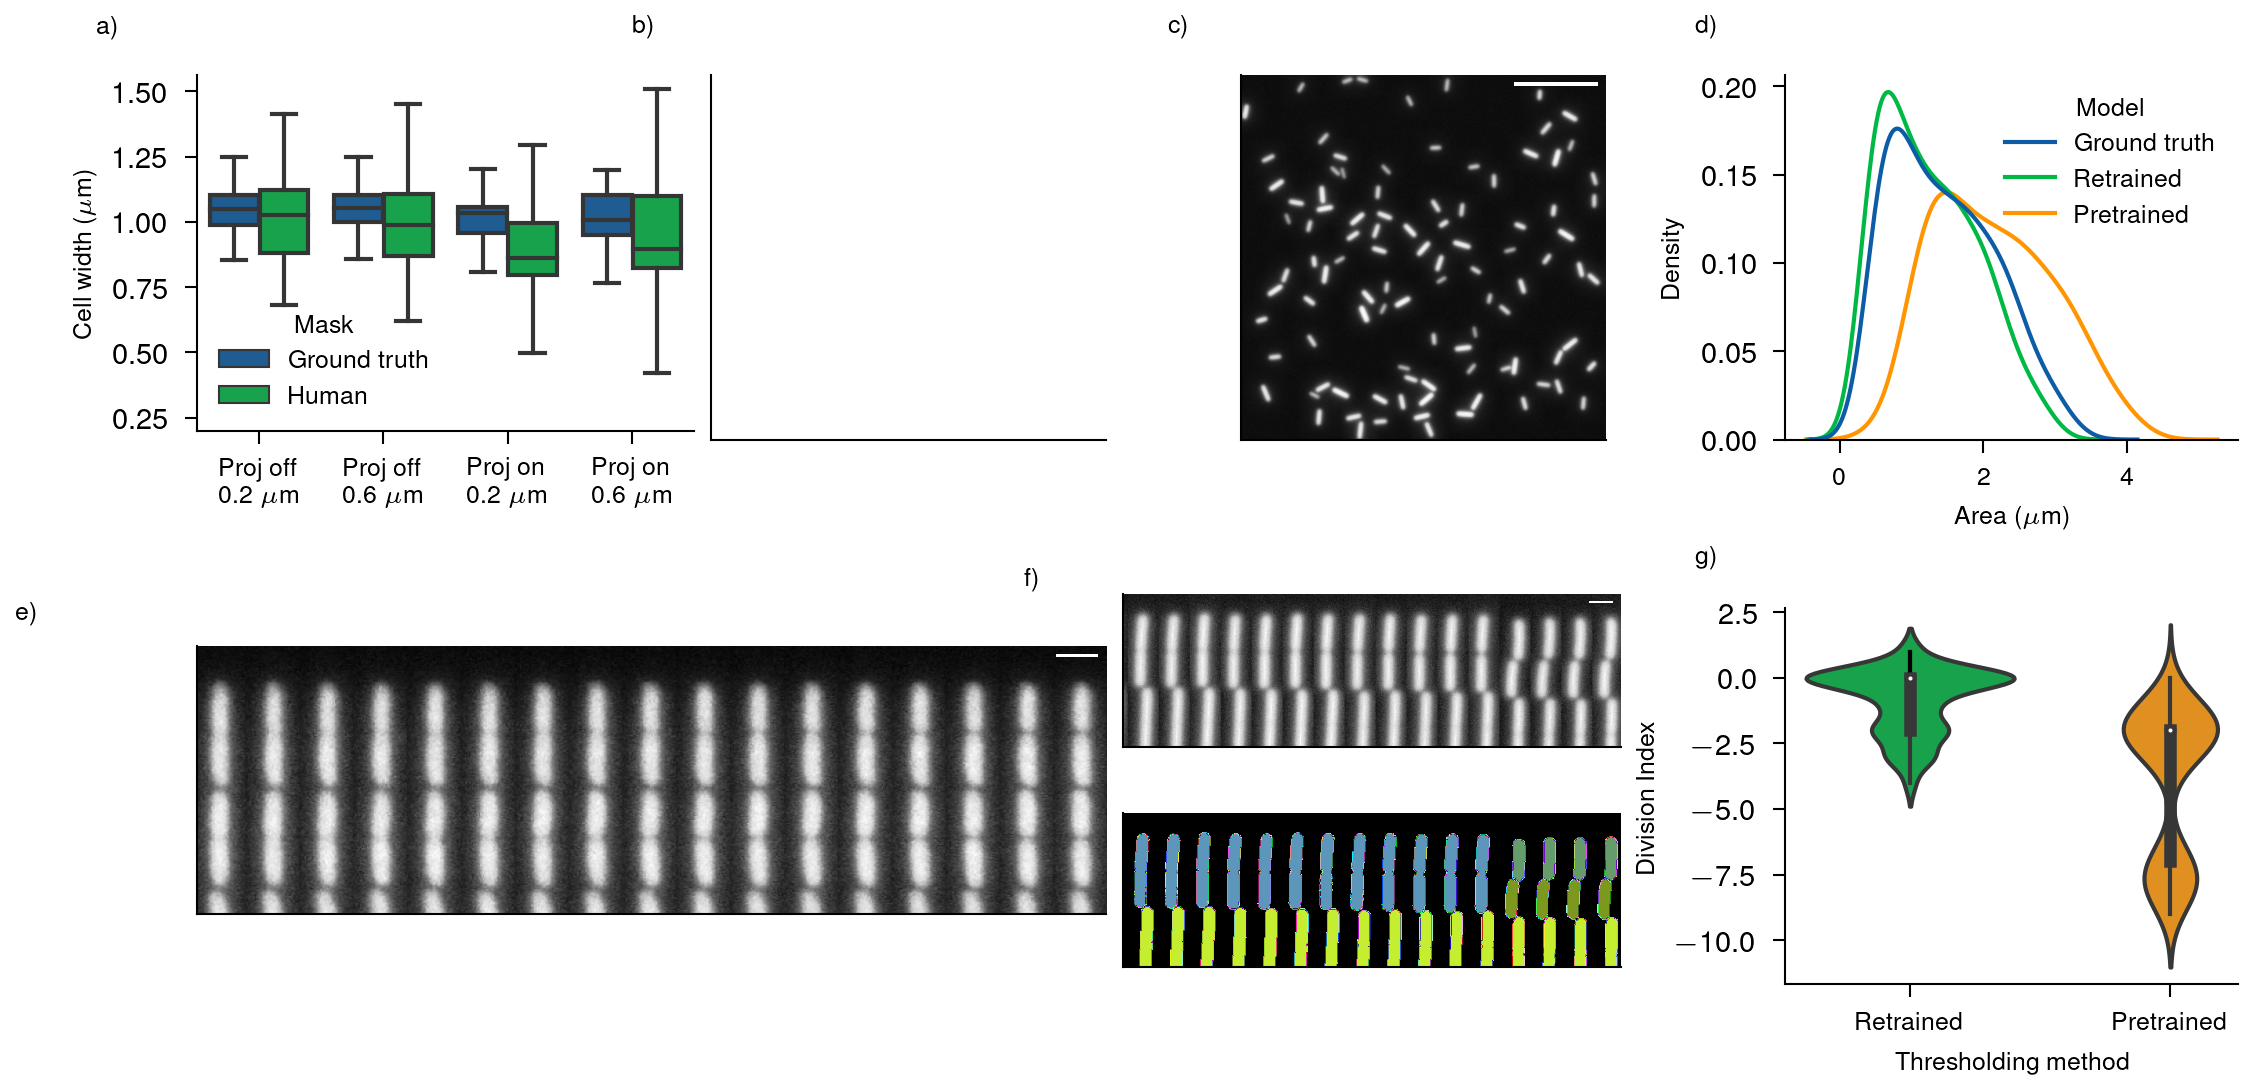

In [15]:
######### Main figure #############
cm = 1/2.54
fig = plt.subplots(figsize = (22.3*cm,10*cm), dpi = 300)
a = matplotlib.cm.get_cmap('Set2')
plt.subplots_adjust(hspace=100)

############ Human annotation error ###############
HUMAN_ANNOTATION = plt.subplot2grid((24, 20), (0, 0), colspan=5, rowspan=10)
plt.text(-.2, 1.165, 'a)', ha='left', va='top', transform=HUMAN_ANNOTATION.transAxes)

sns.boxplot(data = all_regionprops, y = "minor_axis_length", x = "Projection/Wavelength", hue = "Mask", showfliers = False, ax = HUMAN_ANNOTATION)
plt.xlabel(" ")
plt.ylabel("Cell width ($\mu$m)")
plt.ylim(0.2,)
HUMAN_ANNOTATION.set_xticklabels(["Proj off\n0.2 $\mu$m", "Proj off\n0.6 $\mu$m", "Proj on\n0.2 $\mu$m", "Proj on\n0.6 $\mu$m"])
############ Training schematic ###############

TRAINING_SCHEMATIC = plt.subplot2grid((6, 20), (0, 5), colspan=4, rowspan=3)
plt.text(-.2, 1.165, 'b)', ha='left', va='top', transform=TRAINING_SCHEMATIC.transAxes)

TRAINING_SCHEMATIC.set_yticks([])
TRAINING_SCHEMATIC.set_xticks([])


########### Synthetic FOV ##############

synthetic_FOV = np.array(Image.open("../../human_annotation_quality/projection_analysis_cw/training_data//on_0.6_0000.png"))

SYNTH_FOV = plt.subplot2grid((6, 20), (0, 9), colspan=6, rowspan=3)
plt.text(-.2, 1.165, 'c)', ha='left', va='top', transform=SYNTH_FOV.transAxes)

SYNTH_FOV.set_yticks([])
SYNTH_FOV.set_xticks([])

SYNTH_FOV.imshow(synthetic_FOV, cmap="Greys_r")
scalebar = ScaleBar(0.065, "um", length_fraction=0.25, scale_loc="none", box_alpha=0, color="white", box_color="k") # 15 micron
SYNTH_FOV.add_artist(scalebar)

########### Area distribution #############

AREA_DIST = plt.subplot2grid((6, 40), (0, 31), colspan=16, rowspan=3)
plt.text(-.2, 1.165, 'd)', ha='left', va='top',  transform=AREA_DIST.transAxes)

area_dist_data = pd.read_pickle("../../Omnipose_pretrained_vs_retrained/omnipose_size_data.pickle")
area_dist_data.loc[area_dist_data['Model'] == "Syntrained", 'Model'] = "Retrained"
sns.kdeplot(data = area_dist_data, hue = "Model", x = "area", bw_adjust=1.7)
plt.xlabel("Area ($\mu$m)")
plt.ylabel("Density")
####### Fast imaging panel ##########

FAST_FL_IMG = plt.subplot2grid((30, 20), (16, 0), colspan=9, rowspan=14)
plt.text(-.2, 1.165, 'e)', ha='left', va='top',  transform=FAST_FL_IMG.transAxes)
FAST_FL_IMG.set_yticks([])
FAST_FL_IMG.set_xticks([])
FAST_FL_IMG.imshow(
    np.array(Image.open("example_mcherry_30s.png"))[:,160:], cmap="Greys_r"
)
scalebar = ScaleBar(0.065, "um", length_fraction=0.05, scale_loc = "none", box_alpha = 0, color="white", box_color="k") # 2 micron
FAST_FL_IMG.add_artist(scalebar)

####### Synth  fast image ##########

SYNTH_FL_FAST_IMG = plt.subplot2grid((30, 20), (16, 9), colspan=5, rowspan=7)
plt.text(-.2, 1.165, 'f)', ha='left', va='top',  transform=SYNTH_FL_FAST_IMG.transAxes)

SYNTH_FL_FAST_IMG.set_yticks([])
SYNTH_FL_FAST_IMG.set_xticks([])
SYNTH_FL_FAST_IMG.imshow(
    np.array(Image.open("example_syn_fluo.png"))[:,72:-120], cmap="Greys_r"
)
scalebar = ScaleBar(0.065, "um", length_fraction=0.05,  scale_loc = "none", box_alpha = 0, color="white", box_color="k") # 2 micron
SYNTH_FL_FAST_IMG.add_artist(scalebar)
####### Synth masks #############

SYNTH_FL_FAST_MASK = plt.subplot2grid((30, 20), (16+7, 9), colspan=5, rowspan=7)
SYNTH_FL_FAST_MASK.set_yticks([])
SYNTH_FL_FAST_MASK.set_xticks([])
random_cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
random_cmap.colors[0,:] = 0
SYNTH_FL_FAST_MASK.imshow(
    np.array(Image.open("example_syn_mask.png"))[:,72:-120], cmap=random_cmap
)



########### Division time distribution ###########

div_time_data = pd.read_pickle("../../division_time_analysis/division_data.pickle")
DIVISION_TIME = plt.subplot2grid((30, 40), (17, 31), colspan=10, rowspan=14)
plt.text(-.2, 1.165, 'g)', ha='left', va='top',  transform=DIVISION_TIME.transAxes)

sns.violinplot(data=div_time_data.query("`Thresholding method` == 'Omnipose retrained' or `Thresholding method` == 'Omnipose pretrained'"), y="Division Index", x="Thresholding method", palette = ["C1", "C2"])
plt.plot([0,0],[0,1], c = "k")
DIVISION_TIME.set_xticklabels(["Retrained", "Pretrained"])


plt.savefig("figure_3.svg")